In [1]:
import os
import re
from string import punctuation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm, naive_bayes
from sklearn.metrics import ConfusionMatrixDisplay
import torch
from torch import nn

# Классификация программ политических партий

## Чтение данных

В данной работе используются программы политических партий из англоязычных стран, собранные в рамках проекта [Manifesto](https://manifesto-project.wzb.eu/).
В качестве исходных данных используются:
* датасет с информацией о всех политических программах (`MAIN_DATASET`), в т.ч., различные метрики, которые и будут использоваться для разбиения всех программ на классы;
* датасет с информацией о всех политических партиях (`PARTY_DATASET`);
* набор текстов политических программ партий (434 шт.).

In [2]:
ROOT_PATH = os.path.split(os.getcwd())[0]
DATA_DIR = os.path.join(ROOT_PATH, 'data')
MAIN_DATASET = os.path.join(DATA_DIR, 'MPDataset_MPDS2021a.csv')
PARTY_DATASET = os.path.join(DATA_DIR, 'parties_MPDataset_MPDS2021a.csv')
RAW_DIR = os.path.join(DATA_DIR, 'raw')

In [3]:
df_main = pd.read_csv(MAIN_DATASET)
df_main.sample(5)

,country,countryname,oecdmember,eumember,edate,date,party,partyname,partyabbrev,parfam,...,per608_3,per703_1,per703_2,rile,planeco,markeco,welfare,intpeace,datasetversion,id_perm
3796,86,Hungary,10,20,10/05/1998,199805,86522,Christian Democratic People’s Party,KDNP,50,...,NaN,NaN,NaN,-4.287,5.853,1.401,15.499,0.082,2021a,8WASBZ
237,12,Norway,10,0,12/09/2005,200509,12320,Norwegian Labour Party,DnA,30,...,NaN,NaN,NaN,-33.293,4.928,0.000,24.219,1.262,2021a,JJ4SW8
3250,74,Turkey,10,0,06/11/1983,198311,74322,Populist Party,HP,30,...,NaN,NaN,NaN,-13.600,7.900,1.500,9.700,0.000,2021a,CF62SD
2801,64,New Zealand,10,0,15/08/1987,198708,64951,New Zealand Democratic Party,NZDP,95,...,NaN,NaN,NaN,-17.431,1.223,8.869,15.596,3.364,2021a,QINMTI
4622,171,Mexico,0,0,05/07/1970,197007,171601,National Action Party,PAN,60,...,NaN,NaN,NaN,-21.583,10.072,0.719,5.755,0.000,2021a,5Y6E3H


In [4]:
df_parties = pd.read_csv(PARTY_DATASET)
df_parties.sample(5)

,country,countryname,party,abbrev,name,name_english,year_min,year_max,is_alliance,max_pervote,max_presvote
268,35,Portugal,35060,PàF,Portugal à Frente,Portugal Ahead,2015,2015,1,40.034000,NaN
1035,95,Serbia,95440,DJB,Dosta je bilo – Sasa Radulovic,Now it’s enough – Sasa Radulovic,2016,2016,0,6.206000,NaN
377,55,Cyprus,55423,KED,Kinima ton Eleftheron Dimokratikon,Free Democrats Movement,1996,1996,0,3.690000,NaN
799,87,Latvia,87521,LPP,Latvijas Pirmā partija,Latvia’s First Party,2002,2002,0,9.569000,NaN
918,92,Poland,92040,KO,Koalicja Obywatelska,Civic Coalition,2019,2019,1,27.396646,NaN


Все тексты программ изначально располагались в отдельных файлах, названия которых состояли из значений столбцов `party` и `date` для этой программы в основном датасете. Также эти файлы были сгруппированы по странам. Соберем все тексты в один `DataFrame`, куда также поместим метрики этих программ: `rile` (right-left), `planeco`, `markeco`, `welfare` и `intpeace` (смысл понятен из названий).

In [5]:
texts = []
text_ids = []
data = []
COLUMNS = ('rile', 'planeco', 'markeco', 'welfare', 'intpeace')

for country in os.listdir(RAW_DIR):
    cur_path = os.path.join(RAW_DIR, country)

    # iterate over documents
    for fname in os.listdir(cur_path):
        if not fname.endswith('.csv'):
            continue
        df = pd.read_csv(
            os.path.join(cur_path, fname),
            quotechar='"',
            encoding='utf-8'
        )
        text = ' '.join(df['text'])
        texts.append(text)

        # find entry in the main dataset
        party, date = map(int, fname[:-4].split('_'))
        row = df_main[(df_main['date'] == date) &
                      (df_main['party'] == party)]
        assert row.shape[0] == 1
        text_ids.append(row['id_perm'].values[0])
        metrics = [row[col].values[0] for col in COLUMNS]
        data.append(metrics)


df_texts = pd.DataFrame(columns=COLUMNS, data=data)
df_texts['id'] = text_ids
df_texts.set_index('id', inplace=True)
df_texts['text'] = texts
df_texts.head()

,rile,planeco,markeco,welfare,intpeace,text
id,,,,,,
16R91Q,3.537,0.723,4.502,6.190,0.000,It’s people that really matter. “Our ability ...
91HRS8,-30.722,11.089,1.119,14.344,0.712,Labour election policy 1969. Towards nationhoo...
7HJL9O,-7.228,1.098,2.745,11.711,0.366,ECONOMY & INFRASTRUCTURE POLICY ACC New Zealan...
6AFU6O,36.327,1.224,23.265,8.163,0.000,Health ACT BELIEVES Rising government expendit...
YEB6QU,-17.325,3.571,2.242,15.236,3.571,AGRICULTURE STRENGTH IN FARMING Despite the ...


## Кластеризация

Т.к. в домашнем задании требовалось сделать не регрессию, а классификация, то выполним кластеризацию всех прочитанных программ с помощью метрик и метода `KMeans`.
Для наглядности составим `DataFrame` из центров полученных кластеров, куда также поместим общее число вошедших в класс программ.

In [6]:
RESCALE = True
N_CLUSTERS = 4

# get metrics from manifesto dataframe
X = np.array(df_texts.loc[:, COLUMNS])
if RESCALE:
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

# classify X with kmeans
model = KMeans(n_clusters=N_CLUSTERS, init='k-means++')
df_texts['cluster'] = model.fit_predict(X)
centers = model.cluster_centers_
if RESCALE:
    centers = scaler.inverse_transform(centers)

# construct DataFrame of cluster centers
df_clusters = pd.DataFrame(data=centers, columns=COLUMNS)
counts = [(df_texts['cluster'] == i).sum() for i in range(N_CLUSTERS)]
df_clusters['count'] = counts

df_clusters

,rile,planeco,markeco,welfare,intpeace,count
0,28.764206,1.290471,14.714441,5.880353,0.540809,68
1,-20.993962,3.451736,1.413462,24.596368,0.975377,106
2,0.643881,2.732530,3.148276,10.024595,1.167676,185
3,-18.926067,9.450387,2.764827,13.399000,3.192307,75


Полученные классы выглядят вполне разумно, посмотрим, программы каких партий вошли в каждый.

In [7]:
for cluster in range(N_CLUSTERS):
    print(f'Cluster #{cluster}')
    counts = {}
    mask = df_texts['cluster'] == cluster
    for id in df_texts.index[mask]:
        row = df_main[df_main['id_perm'] == id]
        assert row.shape[0] == 1
        party_id = row['party'].values[0]
        row = df_parties[df_parties['party'] == party_id]
        assert row.shape[0] == 1
        party_name = row['name_english'].values[0]
        country = row['countryname'].values[0]
        name = country + ': ' + party_name
        counts[name] = counts.get(name, 0) + 1

    for name in sorted(counts.keys()):
        print(f'{name} - {counts[name]} manifesto(s)')
    print()

Cluster #0
Australia: Country Liberal Party - 1 manifesto(s)
Australia: Democratic Labor Party - 1 manifesto(s)
Australia: Liberal National Party of Queensland - 2 manifesto(s)
Australia: Liberal Party of Australia - 18 manifesto(s)
Australia: National Party of Australia - 14 manifesto(s)
Canada: Progressive Conservative Party - 1 manifesto(s)
Canada: Reform Party of Canada - 1 manifesto(s)
Ireland: Family of the Irish - 2 manifesto(s)
Ireland: Progressive Democrats - 1 manifesto(s)
Ireland: Soldiers of Destiny - 1 manifesto(s)
New Zealand: ACT New Zealand - 7 manifesto(s)
New Zealand: New Zealand National Party - 5 manifesto(s)
New Zealand: United Future New Zealand - 1 manifesto(s)
South Africa: Freedom Front Plus - 1 manifesto(s)
United Kingdom: Conservative Party - 4 manifesto(s)
United Kingdom: United Kingdom Independence Party - 1 manifesto(s)
United States: Republican Party - 7 manifesto(s)

Cluster #1
Australia: Australian Democrats - 1 manifesto(s)
Australia: Australian Greens

В `DataFame` с текстами программ был добавлен столбец с номерами классов:

In [8]:
df_texts.sample(5)

,rile,planeco,markeco,welfare,intpeace,text,cluster
id,,,,,,,
G7RDAT,12.500,2.865,2.604,9.115,1.562,A New Covenant with the American People Two hu...,2
Z9F6OU,-10.843,0.000,0.000,16.867,3.614,"Whatever shape the next Parliament takes, the ...",2
3EMI9X,-47.917,3.869,0.000,33.036,0.595,Despite government parties’ claims of economic...,1
HTIBL8,5.674,1.064,7.092,8.511,0.355,Federal Labor Campaign Launch Speech - 14th No...,2
YRD58O,-18.900,2.700,0.400,7.500,2.700,'The Real Fight is for Britain' INTRODUCTION ...,2


## Предобработка и векторизация текстов

Сначала выполним простую обработку текстов -- переведём их в нижний регистр, удалим числа и знаки препинания, а также лишние пробельные символы.

In [9]:
for i, row in df_texts.iterrows():
    s = row['text']
    s = s.lower()
    s = re.sub(r'[0-9]+(?:\.[0-9]+)?', '', s)
    for ch in punctuation:
        s = s.replace(ch, '')
    s = re.sub(r'\s+', ' ', s)
    df_texts.loc[i, 'text'] = s

Далее векторизуем тексты с помощью `tf-idf` и разобъём полученный датасет на тренировочный и тестовый.

In [10]:
ENCODING = 'utf-8'
VOCAB_SIZE = 2048

vectorizer = TfidfVectorizer(encoding=ENCODING, max_features=VOCAB_SIZE, stop_words='english')
X = vectorizer.fit_transform(df_texts['text'])
y = np.array(df_texts['cluster'], dtype='uint8')
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=True, test_size=40, stratify=y, random_state=42)

print(f'X_train.shape = {X_train.shape}')
print('Выборка слов из словаря tf-idf:')
print(np.random.choice(vectorizer.get_feature_names_out(), size=20))

X_train.shape = (394, 2048)
Выборка слов из словаря tf-idf:
['placed' 'infrastructure' 'accountable' 'integrated' 'far' 'matter'
 'charges' 'committee' 'reduction' 'roads' 'producers' 'foster' 'th'
 'delivered' 'percentage' 'freight' 'consider' 'similar' 'nurses'
 'seeking']


## Классификация

Сначала попробуем ненейросетевые методы -- наивный байесовский классификатор и SVM.

Accuracy = 0.5


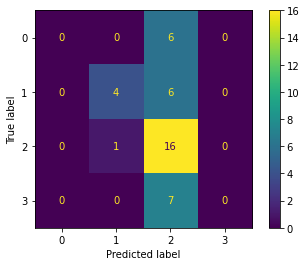

In [11]:
model = naive_bayes.MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'Accuracy = {(y_pred == y_test).sum() / len(y_test)}')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

0.575


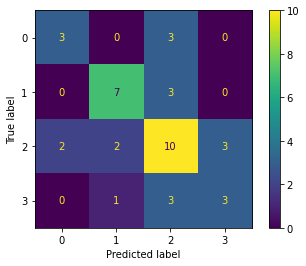

In [12]:
model = svm.LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print((y_pred == y_test).sum() / len(y_test))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

Далее попробуем выполнить классификацию с помощью нейросети. Для начала определим класс, позволяющий более удобно работать с данными.

In [13]:
class Dataset:
    def __init__(self, X: np.ndarray, y: np.ndarray, batch_size: int = 64):
        self.X = X
        self.y = y
        self.num_samples, self.num_features = X.shape
        self.batch_size = batch_size
        self.inds = np.arange(self.num_samples)

    def __len__(self):
        return self.num_samples

    def set_batch_size(self, batch_size: int):
        self.batch_size = batch_size

    def shuffle(self):
        self.inds = np.random.permutation(self.num_samples)

    def __iter__(self):
        if self.batch_size is None:
            return self.X[self.inds], self.y[self.inds]
        start = 0
        while start < len(self):
            stop = min(start + self.batch_size, self.num_samples)
            inds = self.inds[start:stop]
            yield self.X[inds], self.y[inds]
            start = stop

Как показали эксперименты показали, при данной постановке задачи достаточно перцептрона -- т.е. единственного слоя нейросети.
Введение дополнительных слоёв приводило только к проблемам с переобучением.

In [14]:
class Perceptron(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.flatten = nn.Flatten()
        self.stack = nn.Sequential(
            nn.Linear(num_features, num_classes),
            nn.Softmax()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.stack(x)

Обучим нашу модель.

In [15]:
BATCH_SIZE = 8
LEARNING_RATE = 5e-3
EPOCHS = 600

train_dataset = Dataset(X_train.todense(), y_train, batch_size=BATCH_SIZE)
TRAIN_SIZE = X_train.shape[0]
NUM_CLASSES = len(np.unique(y_train))

# choose device and initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Perceptron(
    num_features=X_train.shape[1],
    num_classes=NUM_CLASSES
)
model = model.to(device)

# train the model
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_losses = np.zeros(EPOCHS)
train_acc = np.zeros_like(train_losses)
test_losses = np.zeros_like(train_losses)
test_acc = np.zeros_like(train_losses)
loss_function = nn.NLLLoss()
if not isinstance(X_test, torch.Tensor):
    X_test = torch.tensor(X_test.todense(), dtype=torch.float32, device=device)
    y_test = torch.tensor(y_test, dtype=torch.uint8, device=device)

for i in range(EPOCHS):

    # train loop
    mean_loss = 0.0
    true_count = 0
    for X_j, y_j in train_dataset:
        X_j = torch.tensor(X_j, dtype=torch.float32, device=device)
        y_j = torch.tensor(y_j, dtype=torch.int64, device=device)
        y_pred = model.forward(X_j)
        loss = loss_function(y_pred, y_j)
        mean_loss += loss.item() * X_j.shape[0] / TRAIN_SIZE
        predictions = torch.argmax(y_pred, axis=1)
        true_count += (predictions == y_j).sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_dataset.shuffle()
    train_losses[i] = mean_loss
    train_acc[i] = true_count / TRAIN_SIZE

    # test / validation
    with torch.no_grad():
        y_pred = model.forward(X_test)
        test_losses[i] = loss_function(y_pred, y_test).item()
        pred = torch.argmax(y_pred, axis=1)
        test_acc[i] = (pred == y_test).sum() / len(y_test)

    # display progress
    print('\rEpoch {:4d}, train loss = {:.3f}, test loss = {:.3f}'.format(
            i + 1, train_losses[i], test_losses[i]
            ), end='')

print('\nComplete')

/home/vsg/virtualenvs/torch/lib/python3.9/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch  600, train loss = -0.990, test loss = -0.699
Complete


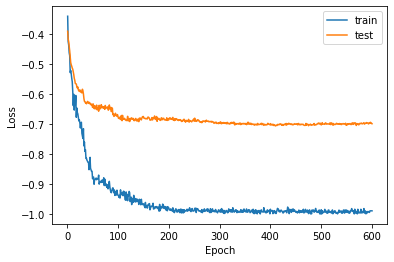

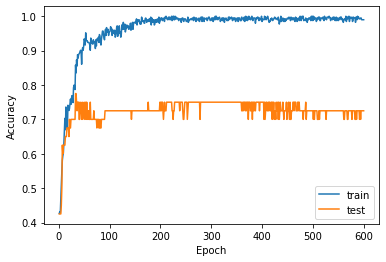

In [18]:
# plot results
epochs = np.arange(1, EPOCHS + 1)
plt.figure()
plt.plot(epochs, train_losses, label='train')
plt.plot(epochs, test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.figure()
plt.plot(epochs, train_acc, label='train')
plt.plot(epochs, test_acc, label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

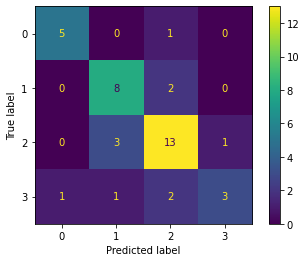

In [19]:
pred = np.argmax(y_pred.cpu().numpy(), axis=1)

ConfusionMatrixDisplay.from_predictions(y_test.cpu().numpy(), pred)

Видно, что в целом точность предсказаний оказалась средней. Возможно, "узким местом" стала `tf-idf` векторизация, но к дедлайну по работе я не успел реализовать кластеризацию с помощью модели, обрабатывающей последовательности. Если у меня все-таки получится это сделать, то, это уже будет после дедлайна, и соответствующие результаты будут лежать в отдельной ветки данного репозитория.